In [6]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.plotting_functions import plot_corr
import seaborn as sns
from src.io_functions import load_data
import os
import json
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, leaves_list

In [2]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [3]:
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc")
    )
    fc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc")
    )
    fcm, scm = connectome_average(fc_group, sc_group)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


In [4]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
    len(scm_nonzero.flatten())
)
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
    zero_rows_fc, fcm_thr, scm_nonzero
)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0)

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


In [31]:
g = 0.7
opt_level = 28
sm_thresh = 5

tree = json.loads(
    open(
        os.path.join(
            project_path,
            "data",
            "processed",
            "n" + str(conn_size),
            "tree_g_" + str(g) + ".json",
        )
    ).read()
)
level, labels = level_from_tree(tree, opt_level)
levels_valid = [l for l in level if len(l) > sm_thresh]

sim = similarity_level(fcm_bin, scm_bin, levels_valid)

sc_intramod = []
fc_intramod = []
mod_size = []
mxmod = []

for idx, mod in enumerate(levels_valid):
    sc_intramod.append(intramodular_modularity(scm_bin, mod))
    fc_intramod.append(intramodular_modularity(fcm_bin, mod))
    mod_size.append(len(mod))
    mxmod.append(pow((sim[idx] * sc_intramod[idx] * fc_intramod[idx]), (1 / 3)))


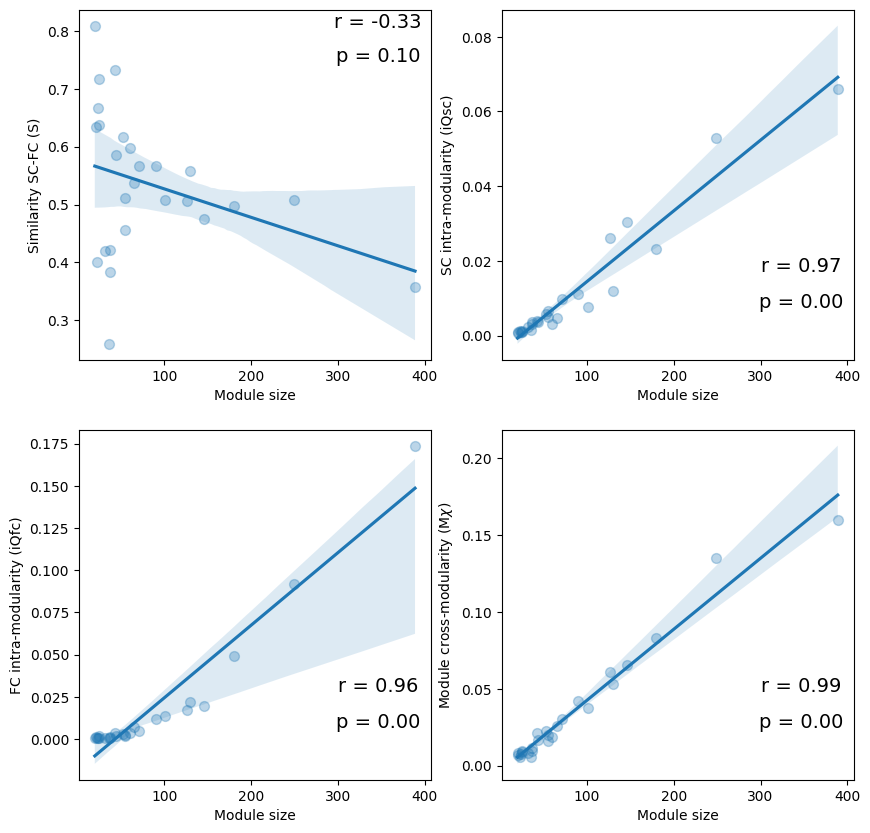

In [37]:
# represent in a three-panel subplot the scatters between sim and mod_size, sc_intramod and mod_size, fc_intramod and mod_size, xmod and mod_size
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.regplot(mod_size, sim, scatter_kws={'alpha':0.3, 's': 50}, ax=axes[0, 0])
axes[0, 0].set_xlabel("Module size")
axes[0, 0].set_ylabel("Similarity SC-FC (S)")
plot_corr(mod_size, sim, 0.85, 0.85, ax=axes[0, 0])

sns.regplot(mod_size, sc_intramod, scatter_kws={'alpha':0.3, 's': 50}, ax=axes[0, 1])
axes[0, 1].set_xlabel("Module size")
axes[0, 1].set_ylabel("SC intra-modularity (iQsc)")
plot_corr(mod_size, sc_intramod, 0.85, 0.15, ax=axes[0, 1])

sns.regplot(mod_size, fc_intramod, scatter_kws={'alpha':0.3, 's': 50}, ax=axes[1, 0])
axes[1, 0].set_xlabel("Module size")
axes[1, 0].set_ylabel("FC intra-modularity (iQfc)")
plot_corr(mod_size, fc_intramod, 0.85, 0.15, ax=axes[1, 0])

sns.regplot(mod_size, mxmod, scatter_kws={'alpha':0.3, 's': 50}, ax=axes[1, 1])
axes[1, 1].set_xlabel("Module size")
axes[1, 1].set_ylabel("Module cross-modularity (M" + r"$\chi$" +")")
plot_corr(mod_size, mxmod, 0.85, 0.15, ax=axes[1, 1])


plt.savefig(
    os.path.join(
        project_path,
        "data",
        "figures",
        "module_xmod_measures.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)